<a href="https://colab.research.google.com/github/WoodaBaker/Python-Projects/blob/master/Alzheimer_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 End-to-end Multi-class Alzheimer Type Classification

This notebook builds an end-to-end image classifier using TensorFlow 2.0 and TensorFlow Hub. The purpose is to determine the dementia level of an Alzheimer patient from their MRI image. This tutorial will utilize the Keras application models: imagenet/mobilenet model and sequential model. 

## 1. Problem 

Differentiate between non-Demented, very-mild-demented, mild-demented, and moderate-demented MRI scans. 

## 2. Data

The data being used is from kaggle's Alzheimer's Dataset (4 class of images).

https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images?datasetId=457093

## 3. Evaluation

The evaluation is a file with prediction probabilities for each MRI brain image.

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so I used a deep learning/transfer learning model.
* There are 4 different categories of different MRI Brain scans (non, verymild, mild, and moderate levels of dementia). 
* There are ~ 6300 total unique values to choose from within the test and train files.
* Test file contains ~ 1300 images.
* Train file contains ~ 5000 images.
* The Test file contains no labels.
* The Train file is labeled.
* I created a CSV file in google sheets and imported as a pandas df. 

In [ ]:
# Update all data into google drive in case Engine backend is disconected. 

In [1]:
 # Import Tensor tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check GPU availability
print("GPU", "available (YESSSS!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.8.2
TF Hub version: 0.12.0
GPU not available :(


## Getting our data ready (turning data into tensors)

With all machine learning models, the data has to be in numerical format.  So that's what I'll be doing first. Turning the images into Tensors (numerical representations).

I'll start by accessing our data and checking out the labels

In [2]:
# Checkout the label of our data
import pandas as pd
labels_csv = pd.read_csv("/content/drive/MyDrive/Alzheimer(s) Data/Alzheimer(s)_labels - Sheet1-3.csv")
print(labels_csv.describe())
print(labels_csv.head())

                 ID dementia_grade
count          5121           5121
unique         5121              4
top     nonDem0.jpg         nonDem
freq              1           2560
            ID dementia_grade
0  nonDem0.jpg         nonDem
1  nonDem1.jpg         nonDem
2  nonDem2.jpg         nonDem
3  nonDem3.jpg         nonDem
4  nonDem4.jpg         nonDem


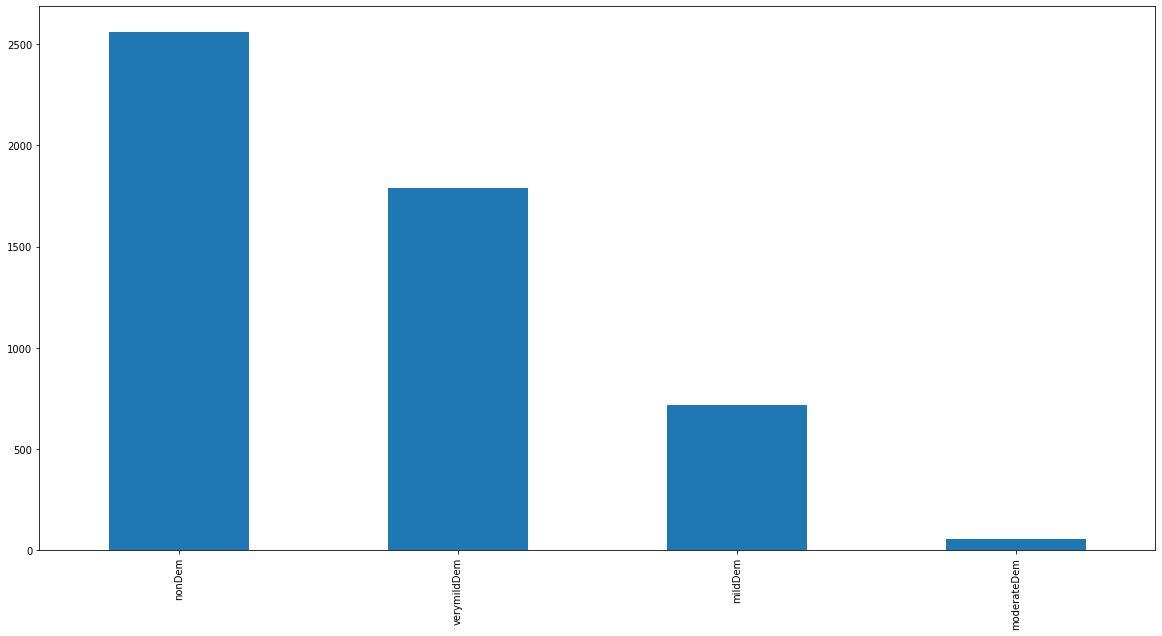

In [3]:
# How many images are there of each dementia grade? 
labels_csv["dementia_grade"].value_counts().plot.bar(figsize=(20,10));


In [4]:
labels_csv["dementia_grade"].value_counts()

nonDem         2560
verymildDem    1792
mildDem         717
moderateDem      52
Name: dementia_grade, dtype: int64

In [5]:
labels_csv.head()

,ID,dementia_grade
0,nonDem0.jpg,nonDem
1,nonDem1.jpg,nonDem
2,nonDem2.jpg,nonDem
3,nonDem3.jpg,nonDem
4,nonDem4.jpg,nonDem


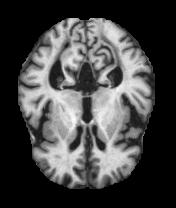

In [6]:
from IPython.display import Image
Image("/content/drive/MyDrive/Alzheimer(s) Data/train(2)/mildDem100.jpg")

# Getting images and their lables

This will display a list of all of our image file parameters.

In [7]:
labels_csv.head()

,ID,dementia_grade
0,nonDem0.jpg,nonDem
1,nonDem1.jpg,nonDem
2,nonDem2.jpg,nonDem
3,nonDem3.jpg,nonDem
4,nonDem4.jpg,nonDem


In [8]:
# Getting path names from image ID's
filenames = ["/content/drive/MyDrive/Alzheimer(s) Data/train(2)/" + fname for fname in labels_csv["ID"]]

# check the first 10
filenames[:10]

['/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem0.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem1.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem2.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem3.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem4.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem5.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem6.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem7.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem8.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem9.jpg']

In [9]:
# Currently only printing 5133 over 5121. Find disconnect
import os
if len(os.listdir("/content/drive/MyDrive/Alzheimer(s) Data/train(2)/")) == len(filenames):
  print("Filenames match actual amount of files! Proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory")

Filenames match actual amount of files! Proceed.


In [10]:
len(filenames)

5121

In [11]:
len(os.listdir("/content/drive/MyDrive/Alzheimer(s) Data/train(2)/"))

5121

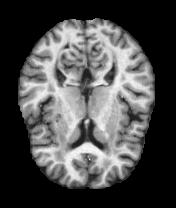

In [12]:
Image(filenames[900])

In [13]:
labels_csv["dementia_grade"][3000]

'verymildDem'

Preparing our labels

In [14]:
import numpy as np
labels = labels_csv["dementia_grade"].to_numpy()
# labels = np.array(labels) # same execution as above
labels

array(['nonDem', 'nonDem', 'nonDem', ..., 'moderateDem', 'moderateDem',
       'moderateDem'], dtype=object)

In [15]:
len(labels)

5121

In [16]:
# Compare number of labels to file names
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Numbber of labels does not match number of filenames, check data directories")

Number of labels matches number of filenames!


In [17]:
len(labels)

5121

In [18]:
len(filenames)

5121

In [19]:
# Find the unique label values
unique_dementia_grade = np.unique(labels)
unique_dementia_grade

array(['mildDem', 'moderateDem', 'nonDem', 'verymildDem'], dtype=object)

In [20]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_dementia_grade

nonDem


array([False, False,  True, False])

In [21]:
# Turn every label into boolean array
boolean_labels = [label == unique_dementia_grade for label in labels]
boolean_labels[:2]

[array([False, False,  True, False]), array([False, False,  True, False])]

In [22]:
len(boolean_labels)

5121

In [23]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_dementia_grade == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there willbe a 1 where the sample label occurs

nonDem
(array([2]),)
2
[0 0 1 0]


In [24]:
print(labels[2])
print(boolean_labels[2].astype(int)) 

nonDem
[0 0 1 0]


In [25]:
boolean_labels[:2]

[array([False, False,  True, False]), array([False, False,  True, False])]

In [26]:

filenames[:10]

['/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem0.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem1.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem2.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem3.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem4.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem5.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem6.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem7.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem8.jpg',
 '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem9.jpg']

### Creating validation set
Since the dataset doesn't contain a validation set, I am goign to create one. 

In [27]:
# Setup x & y variables 
x = filenames
y = boolean_labels

In [28]:
len(filenames)

5121

Start with 500 images and increase as needed. 

In [29]:
# Set number of images to use for experimenting 
NUM_IMAGES = 500 #@param {type: "slider", min:500, max:5000, step:500}

In [72]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split

# Split into training and validation  of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

In [31]:
len(x_train), len(y_train), len(x_val), len(y_val)

(400, 400, 100, 100)

In [71]:
# Check-out the training data
x_train[:5], y_train[:5]

(['/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem249.jpg',
  '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem433.jpg',
  '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem19.jpg',
  '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem322.jpg',
  '/content/drive/MyDrive/Alzheimer(s) Data/train(2)/nonDem332.jpg'],
 [array([False, False,  True, False]),
  array([False, False,  True, False]),
  array([False, False,  True, False]),
  array([False, False,  True, False]),
  array([False, False,  True, False])])

### Preprocessing Images (turning images into Tensors)

To preprocess images into tensors, I'll write a function which does a few things: 
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn `image` (.jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224,224)
6. Return the modified image

In [33]:
# Import a single image & convert image to a Numpy array
from matplotlib.pyplot import imread 
image = imread(filenames[3])
image.shape

(208, 176)

In [34]:
image.max(), image.min()

(255, 0)

In [35]:
image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [70]:
# Turning an image into a tensor
tf.constant(image)

<tf.Tensor: shape=(208, 176), dtype=uint8, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>

In [69]:
# Now preprocess the images
IMG_SIZE = 224

# create a function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turn data into batches
* Yann Lecun: Do not create batches larger than 32.
* Running too many images at once, may not fit into memory.
* TensorFlow is used most effectively when the data is turned into tuples (i.e.):
`(image, label)`

In [38]:
# simple function that returns a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple (image, label)
  """
  image = process_image(image_path)
  return image, label

In [39]:
(process_image(x[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], 

Now that the data is in the form tuples of Tensors: `(image, label)`, all the data can be turned into batches.

In [40]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepath (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Createing validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), #filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating trianing data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor is faster than shuflfing images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the images into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [41]:
# Create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating trianing data batches...
Createing validation data batches...


In [42]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4), dtype=tf.bool, name=None)))

In [43]:
y[0]

array([False, False,  True, False])

## Visualizing Data Batches

Our data is now in batches, however these can be a little hard to understand in this form. Visualize them to make better sense. 

In [44]:
import matplotlib.pyplot as plt
# Create a function for viewing images in a data bacth
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure 
  plt.figure(figsize=(10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    #Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_dementia_grade[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")


In [45]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.bool, name=None))>

In [46]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],
 
 
        [

In [67]:
len(train_images), len(train_labels)

(32, 32)

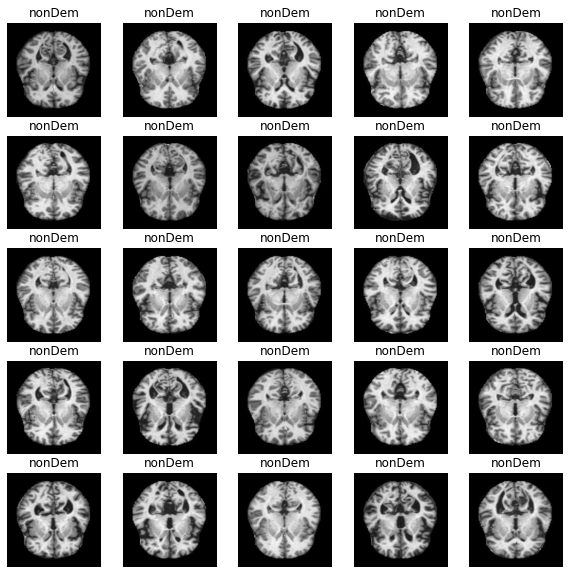

In [68]:
# Now visualize the data in a training batch
show_25_images(train_images, train_labels)

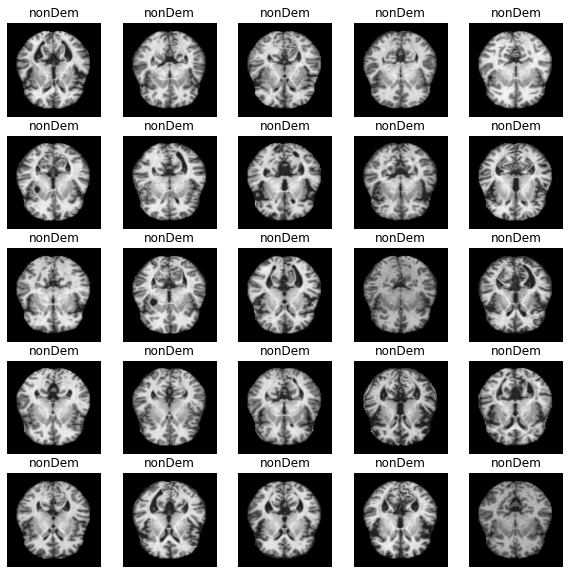

In [79]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

This is one of many ways of building a model. This is called transfer learning.
First we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of out model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5.
* research gate: https://www.researchgate.net/publication/344906528_A_Classification_method_for_Brain_MRI_via_MobileNet_and_Feedforward_Network_with_Random_Weights

In [78]:
IMG_SIZE

224

In [87]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_dementia_grade)
OUTPUT_SHAPE

4

In [98]:
# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now that the inputs, outputs, and model is ready to go. Below will show how to put them together into a keras deep learning model.

Create a function which:
* Takes the input shape, output shape and the model as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it;ll be getting).
* Returns the model. 

All of these steps can be found here: https://www.tensorflow.org/guide/keras/sequential_model

In [99]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Steup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)               
  ])

  # Complete the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [101]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_14 (KerasLayer)  (None, 1001)             5432713   
                                                                 
 dense_14 (Dense)            (None, 4)                 4008      
                                                                 
Total params: 5,436,721
Trainable params: 4,008
Non-trainable params: 5,432,713
_________________________________________________________________
